In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Number of time steps in one epoch
n = 2100 

output = pd.read_csv('output.csv')
output['epoch'] = output.index // n 
output2 = pd.read_csv('output_2.csv')
output2['epoch'] = output2.index // n 
output2['epoch'] = output2['epoch']  + output['epoch'].max() + 1
data = pd.concat([output,output2]).reset_index()

data['log_response_time'] = np.log(data['response_time'])
epoch_boundaries = data[data['epoch'] - data['epoch'].shift() == 1].index

# Load Profile
To train the agent in a an environment similar to production environments, we collected the daily transaction load of our live systems and generated a load profile. We, then, normalized the profile so that it fits to the capacity of the testing environment of the agent. In figure below, the final load profile is shown. 

Text(0.5, 0, 'time index')

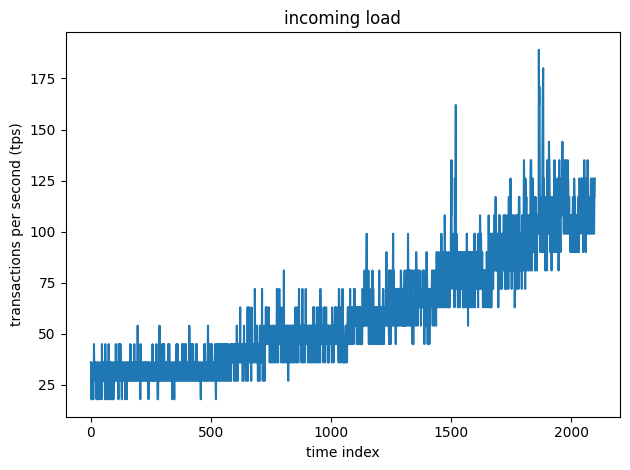

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,sharex=True)
fig.set_tight_layout(True)
ax.plot(data.loc[:n-1,'expected_tps'])
ax.set_title('incoming load')
ax.set_ylabel('transactions per second (tps)')
ax.set_xlabel('time index')


# Resolution and Repeating
In the load profile we generated above, there are 2100 data points corresponding to almost 6 years of real-data in daily resolution. It is obvious that training the agent in a daily fashion is not feasible. Instead, we wait only a minute between actions. So, training the agent on this load profile requires almost 35 hours. After 2100 actions, we rewind the load profile to the beginning and resume training. 

When the agent finishes a load profile and starts over, we say it enters a new epoch. In the figure below, there are five epochs. Please note that the third epoch is short because there was an unexpected infrastructure failure during training, so the training had to start from the beginning of the load profile. The last (fifth) epoch is unfinished because the training is still going on.


(0.0, 9350.0)

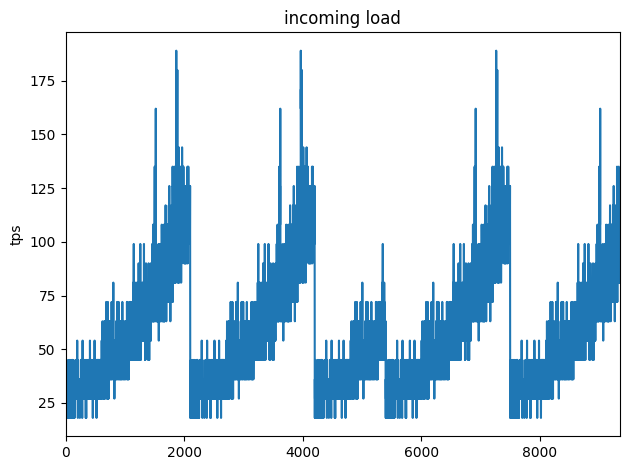

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=1,sharex=True)
fig.set_tight_layout(True)
axes.plot(data['expected_tps'])
axes.set_title('incoming load')
axes.set_ylabel('tps')
axes.set_xlim((0, len(data)))



# Evolution of response time
One the first metrics to look at when trying to understand whether the agent is training well is the response time. If we don't touch any of the setting of an application, we should expect more of less the same response time behaviour under the same load. Contrary, if we fine tune the application, we should expect a significant decrease in response time distribution.  Therefore, if our agent is training well, then it must be able to arrange the settings of the application, hence it should decrease the response time when the application face the same load profile. 

This figure below displays the expected behaviour. On top, we display the complete load profile used in the training. On bottom, response times of the application are shown.  As you see, the outliers are becoming rare even if the same load profile is applied. This is an indication that the agent learns to choose settings to lower than the response times.



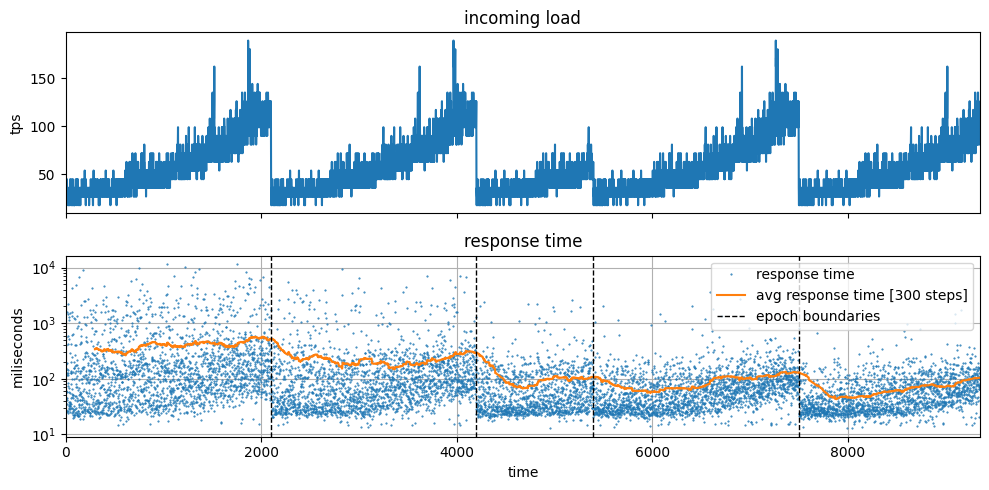

In [27]:
fig, axes = plt.subplots(nrows=2,ncols=1,figsize=(10,5),sharex=True)
fig.set_tight_layout(True)
axes[0].plot(data['expected_tps'])
axes[0].set_title('incoming load')
axes[0].set_ylabel('tps')
axes[0].set_xlim((0, len(data)))

avg_response_time = pd.Series(data['response_time']).rolling(300).mean()

axes[1].plot(data['response_time'],'.',markersize=1,label='response time')
axes[1].plot(avg_response_time, label='avg response time [300 steps]')
for epoch, epoch_boundary in zip(range(len(epoch_boundaries)), epoch_boundaries):
    axes[1].axvline(x=epoch_boundary, color='k', linestyle='--', linewidth=1, label='epoch boundaries' if epoch == 0 else None)
axes[1].set_yscale('log')
axes[1].set_xlabel('time')
axes[1].set_title('response time')
axes[1].set_ylabel('miliseconds')
axes[1].grid(True)
axes[1].legend()
plt.show()

# Epoch vs Response time 
Another way to display the effect of the agent on the response time, we aggregate the response times with respect to epochs and display the response times as box plots. The first epoch corresponds to the first time the agent is faced to the load profile. 

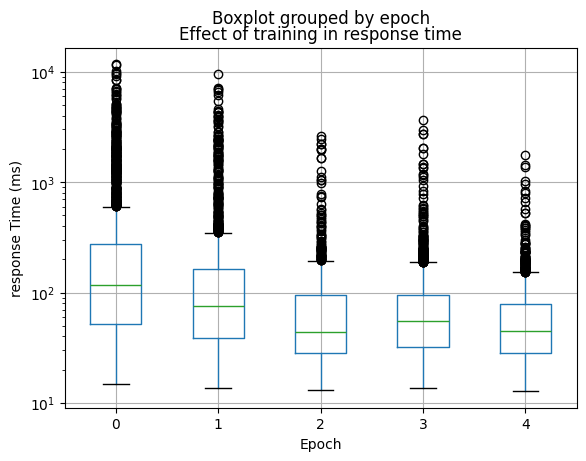

In [28]:
data.boxplot(by='epoch', column='response_time')
plt.xlabel('Epoch')
plt.ylabel('response Time (ms)')
plt.yscale('log')
plt.title('Effect of training in response time')
plt.show()

# Monitoring Reward
If our agent is training well, then the agent should learn to get high rewards as time passes. Let's draw step vs reward plot to see this. 
Red vertical lines correspond to the epoch boundaries.

* By design, we put an upper limit for reward and this boundary is visible in the plot.
* As time passes, rewards are getting better.
* At the end of each epoch, reward is dropped possibly because of increased load.

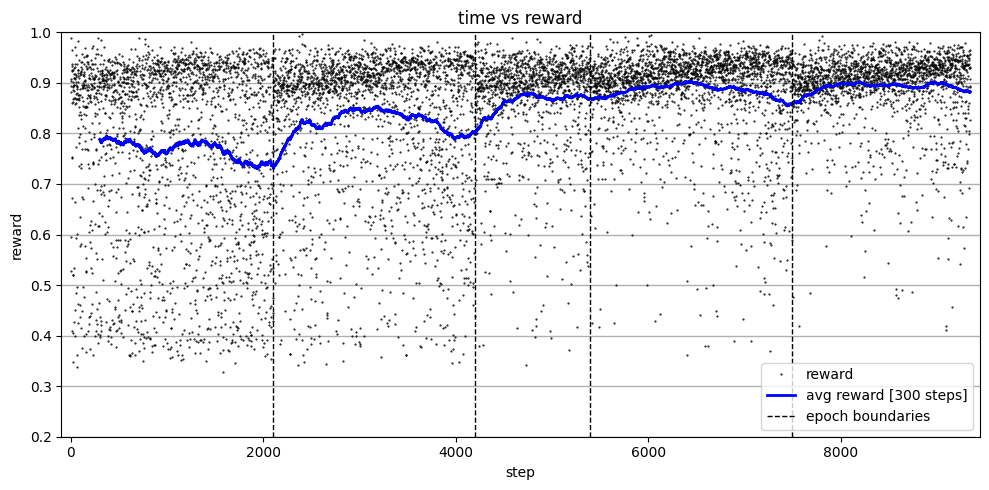

In [29]:
avg_reward = pd.Series(data['reward']).rolling(300).mean()

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,5),sharex=True)
fig.set_tight_layout(True)
ax.plot(data['reward'], '.', label="reward", markersize=1, color='k')
ax.plot(avg_reward,label='avg reward [300 steps]', linewidth=2,color='b')
ax.set_xlabel('step')
ax.set_ylabel('reward')
ax.set_title('time vs reward')
ax.yaxis.grid(True,  lw = 1)
ax.set_yscale('linear')
ax.set_axisbelow(True)
ax.set_ylim([0.2,1])
ax.set_xlim([-100,len(data)+100])
for epoch, epoch_boundary in zip(range(len(epoch_boundaries)), epoch_boundaries):
    ax.axvline(x=epoch_boundary, color='k', linestyle='--', linewidth=1, label='epoch boundaries' if epoch == 0 else None)
ax.legend()
plt.show()